<h1><span style='color:#8E5609;background:white'> IP Address Analysis - Team Cymru</span></h1>

---
## Load Dataset

In [1]:
import os
import ipaddress
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date, datetime
import dns.query, dns.message, dns.reversename, dns.resolver

# Seaborn / Matplotlib Settings
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# This is our enriched TeamCymru Dataset
# https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
# We want to set the ASN datatype to object so its isn't interpreted as an int
df_tc = pd.read_csv("../data_sets/download/src_ip_failed_login_attempts_team_cymru_ip_to_asn_mapped.csv",header=0,dtype={'ASN': object})

---
## Review Datase

In [3]:
df_tc.head(10)

,ip_count,src_ip,ASN,BGP Prefix,Country Code,RIR,Allocation Date,AS Description,AS Peers
0,1,102.91.5.112,29465,102.91.5.0/24,NG,AFRINIC,2018-09-04,"VCG-AS, NG",16637
1,1,103.100.4.46,132116,103.100.4.0/24,IN,APNIC,2017-08-31,"ANINETWORK-IN Ani Network Pvt Ltd, IN",9498
2,1,103.155.210.207,133007,103.155.210.0/24,IN,APNIC,2020-09-16,"UCN-AS UCN CABLE NETWORK PVT. LTD, IN",17762
3,1,103.39.30.30,134866,103.39.30.0/24,IN,APNIC,2014-09-16,"SSCN-AS Sscn Pvt Ltd, IN",136334
4,1,103.86.19.113,45916,103.86.19.0/24,IN,APNIC,2017-02-16,"GTPL-AS-AP Gujarat Telelink Pvt Ltd, IN",4755 55836
5,1,104.5.71.254,7018,104.0.0.0/12,US,ARIN,2014-01-16,"ATT-INTERNET4, US",1239 1299 2914 3257 3356 6939
6,1,106.204.132.70,45609,106.204.128.0/18,IN,APNIC,2011-03-17,BHARTI-MOBILITY-AS-AP Bharti Airtel Ltd. AS fo...,9498
7,1,106.204.152.180,45609,106.204.128.0/18,IN,APNIC,2011-03-17,BHARTI-MOBILITY-AS-AP Bharti Airtel Ltd. AS fo...,9498
8,1,106.205.159.99,45609,106.205.128.0/18,IN,APNIC,2011-03-17,BHARTI-MOBILITY-AS-AP Bharti Airtel Ltd. AS fo...,9498
9,1,106.205.236.6,45609,106.205.224.0/20,IN,APNIC,2011-03-17,BHARTI-MOBILITY-AS-AP Bharti Airtel Ltd. AS fo...,9498


In [4]:
# Set RIR value to upper case
df_tc['RIR'] = df_tc['RIR'].str.upper()

### Describe

- Generate descriptive statistics.
  - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html

### Observation(s)

This data is useful as it provides insight into starting values we could filter on intially for number of times a src_ip was seen during a login.  In this instance we can see that 50% of the src_ip's attempting to login did so (9) times. In this case the 25% value is fairly high.

In [5]:
df_tc.describe()

,ip_count
count,1948.000000
mean,16.690965
std,18.956197
min,1.000000
25%,3.000000
50%,9.000000
75%,25.000000
max,172.000000


### Nunique

- Count number of distinct elements in specified axis.
  - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.nunique.html

### Observation(s)

- Confirm that the src_ip matches the number of entries as this dataset has provided an an aggregate count.
- We can see that for **1948** entries there are **248** unique ASN's
- There are only (5) RIR's the 6th comes from the NaN entries as they haven't been dropped.
- There are only **207** unique peering arrangements. This can be misleading however since the AS Peer number ordering is most likely being treated as a unique string.


In [6]:
df_tc.nunique()

ip_count             82
src_ip             1948
ASN                 247
BGP Prefix         1029
Country Code         38
RIR                   6
Allocation Date     356
AS Description      247
AS Peers            205
dtype: int64

### Check NaN Values

In [7]:
df_tc.isna().sum()

ip_count            0
src_ip              0
ASN                11
BGP Prefix         11
Country Code        1
RIR                 0
Allocation Date    12
AS Description      0
AS Peers           11
dtype: int64

### If there are NaN values check the lookup
* Lookup tool - https://asn.cymru.com/

In [9]:
df_tc[df_tc.isna().any(axis=1)]

,ip_count,src_ip,ASN,BGP Prefix,Country Code,RIR,Allocation Date,AS Description,AS Peers
336,2,1.38.152.142,NaN,NaN,None,NONE,NaN,None,NaN
384,2,2402:3a80:1529:922a:301a:3ee1:7bfb:4eff,NaN,NaN,None,NONE,NaN,None,NaN
385,2,2402:3a80:160c:dedd:0:10:273d:e201,NaN,NaN,None,NONE,NaN,None,NaN
530,3,2402:3a80:1a26:8fce:ecb2:a83b:1aa6:3bee,NaN,NaN,None,NONE,NaN,None,NaN
612,4,106.76.75.120,NaN,NaN,None,NONE,NaN,None,NaN
707,5,114.31.152.118,NaN,NaN,None,NONE,NaN,None,NaN
822,6,2402:3a80:1a24:9db5:cf0:7c9f:ed22:9a04,NaN,NaN,None,NONE,NaN,None,NaN
878,7,2402:3a80:19a6:b963:c923:2b27:dc9:7344,NaN,NaN,None,NONE,NaN,None,NaN
1346,19,2402:3a80:1f22:fc69::1da7:bd15,NaN,NaN,None,NONE,NaN,None,NaN
1677,42,162.247.24.22,14434,162.247.24.0/21,NaN,ARIN,NaN,"VIPNAS1, VI",394680


---
## Analyze Data Set

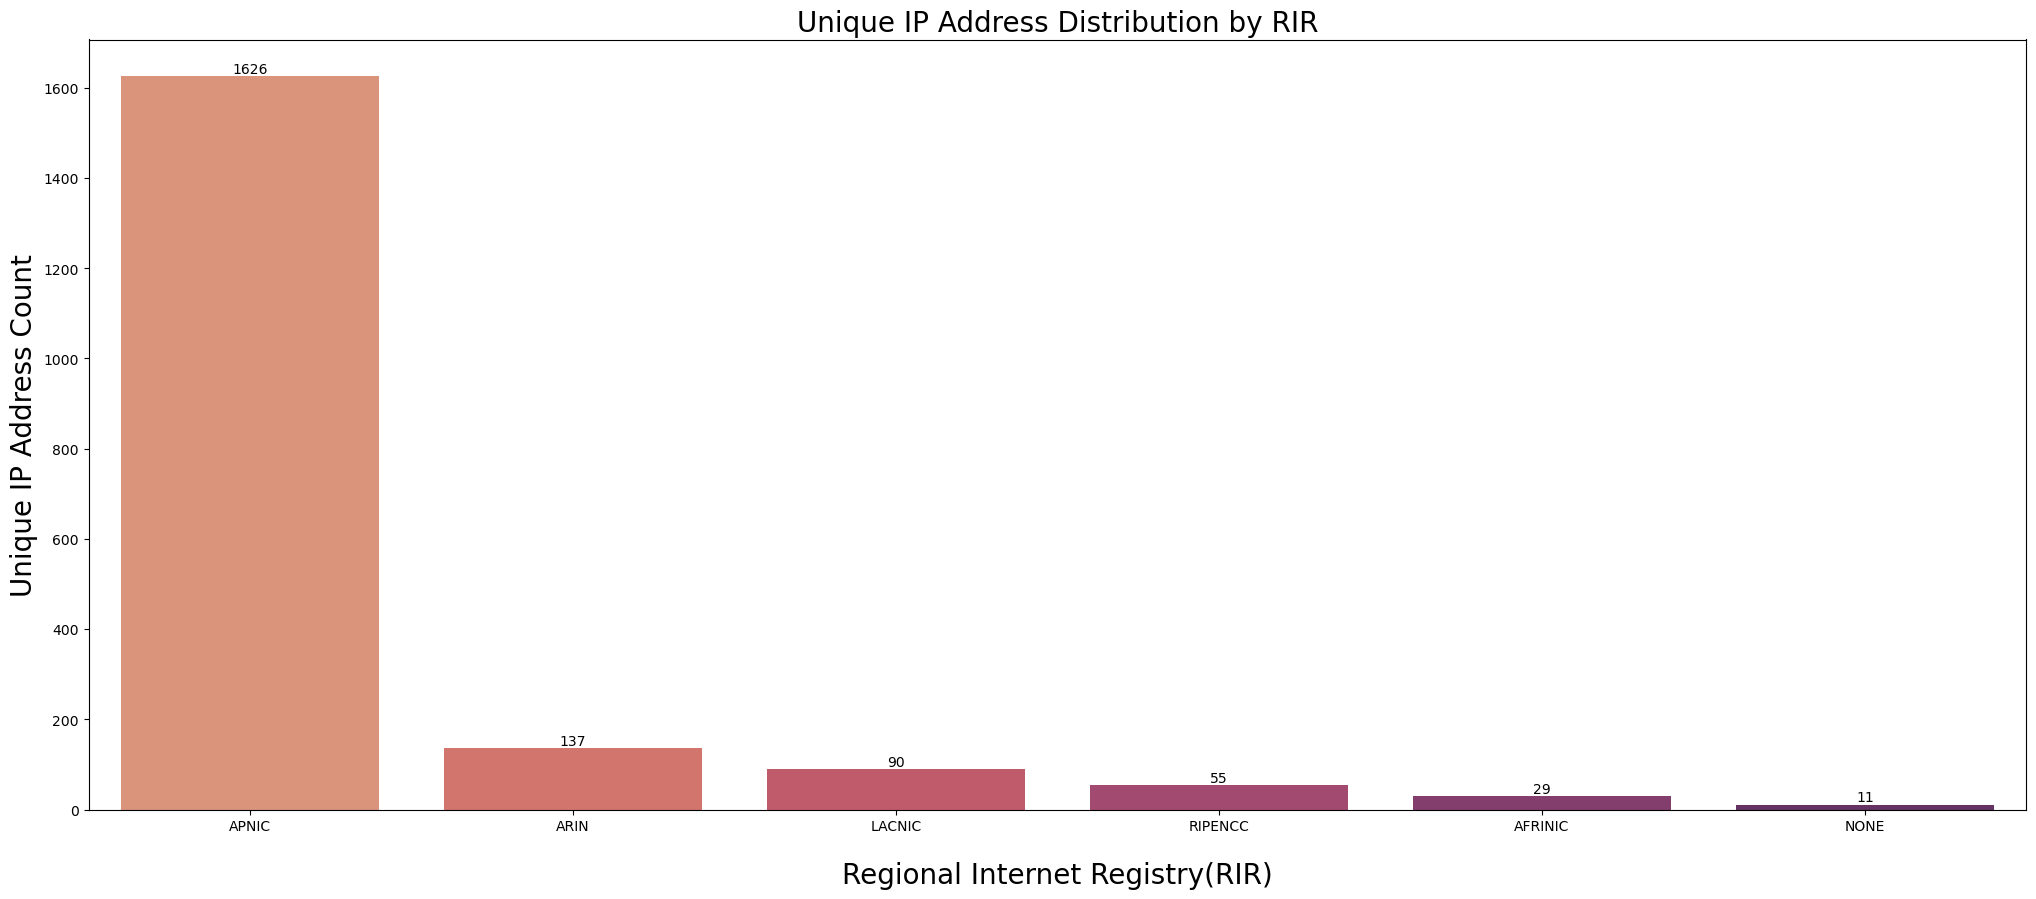

In [11]:
fig, ax = plt.subplots(figsize=(25,10))
sns.countplot(x='RIR',data=df_tc, order=df_tc.RIR.value_counts().index, palette="flare", ax=ax, lw=1)
ax.set_title("Unique IP Address Distribution by RIR", fontsize=20) 
ax.set_xlabel("Regional Internet Registry(RIR)", fontsize=20, labelpad=20)
ax.set_ylabel("Unique IP Address Count", fontsize=20)

# Loop through index to provide values to place at the top
# of the bars. Use count to provide graph locations for 
# ax.text
count = 0

for rir, v in df_tc.RIR.value_counts().items():
    ax.text(count,v,v, ha="center", va="bottom")
    count = count+1

### 2. Unique IP Address Distribution by ASN

* We want to look at the distribution of IP addresses from their assigned Atonmous System Number(ASN). 
* ASN's are assigned via RIR's and represent an organizations collective IP address prefixes.
* ASN allow for multi-homing (multiple ISP transit providers) and control over how network prefixes are presented and routed to on the Ineternet.
* Usually this allows you to have a starting point to report network abuse.

ASN Resources

* https://datatracker.ietf.org/doc/rfc1930
* https://datatracker.ietf.org/doc/rfc5396
* https://datatracker.ietf.org/doc/rfc6793


In [31]:
# Show All Rows
#pd.set_option('display.max_rows', 30)

# Group by ASN and RIR with counts.
# Drop the other rows here as part of this temp processing.
df_tc_asn = df_tc.drop(columns=["src_ip","BGP Prefix","Country Code","Allocation Date","AS Peers"])

df_tc_asn.head(25)

,ip_count,ASN,RIR,AS Description
0,1,29465,AFRINIC,"VCG-AS, NG"
1,1,132116,APNIC,"ANINETWORK-IN Ani Network Pvt Ltd, IN"
2,1,133007,APNIC,"UCN-AS UCN CABLE NETWORK PVT. LTD, IN"
3,1,134866,APNIC,"SSCN-AS Sscn Pvt Ltd, IN"
4,1,45916,APNIC,"GTPL-AS-AP Gujarat Telelink Pvt Ltd, IN"
5,1,7018,ARIN,"ATT-INTERNET4, US"
6,1,45609,APNIC,BHARTI-MOBILITY-AS-AP Bharti Airtel Ltd. AS fo...
7,1,45609,APNIC,BHARTI-MOBILITY-AS-AP Bharti Airtel Ltd. AS fo...
8,1,45609,APNIC,BHARTI-MOBILITY-AS-AP Bharti Airtel Ltd. AS fo...
9,1,45609,APNIC,BHARTI-MOBILITY-AS-AP Bharti Airtel Ltd. AS fo...


In [30]:
df_arin = df_tc_asn.groupby('RIR').get_group('ARIN')
df_apnic = df_tc_asn.groupby('RIR').get_group('APNIC')
df_ripencc = df_tc_asn.groupby('RIR').get_group('RIPENCC')
df_lacnic = df_tc_asn.groupby('RIR').get_group('LACNIC')
df_afrinic = df_tc_asn.groupby('RIR').get_group('AFRINIC')

In [16]:
# Set the bar label to the value count of unique IP addresses per ASN
def bar_label_text(_rir_df, _axes_val):
    '''
    Parameters
    ----------
    
    _rir_df:
        This is the specific group-by data-frame(df) for the specific RIR. This 
        reduces the amount of data that needs to be passed to the function for
        processing.
        
    _axes_val:
        We are subplotting one graph for each RIR, (5) in total, within a single 
        figure. This values defines the subplot that we current want to process.
        
    Returns
    -------
    
    There are no return values as this is setting the respective 'axs[x]' values.
    
    Notes
    -----
    
    We pass in the RIR data-frame that has the ASN and its total unique IP address
    count. We unpack the ASN and its value count to determine the needed (x,y)
    corordinate values and the value text to be printed. 
    
    An example:
    
    [[ASN, Unique IP Address Value Count],[ASN, Unique IP Address Value Count],..]
    [[1234,15],[5689,67],...]]
    
    Following the Axes.text inputs:
    
    https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html#matplotlib.axes.Axes.text
    
    Our X value will be the index location of [1234,15] and our Y location will be the value for the ASN entry which is (15). 
    We want to print the unique IP address count value as our text, S. This also happens to be the same data that is unpacked
    into variable V. 
    
    A single entry would look like this:
    
    axs[_axes_val].text(0,15,15, ha="center", va="bottom"
    axs[_axes_val].text(1,67,67, ha="center", va="bottom"
    '''
    
    for asn, v in _rir_df.ASN.value_counts().items():
        axs[_axes_val].text(_rir_df.ASN.value_counts().index.get_indexer([asn]),v,str(v), ha="center", va="bottom", fontstyle='italic', fontsize='15')

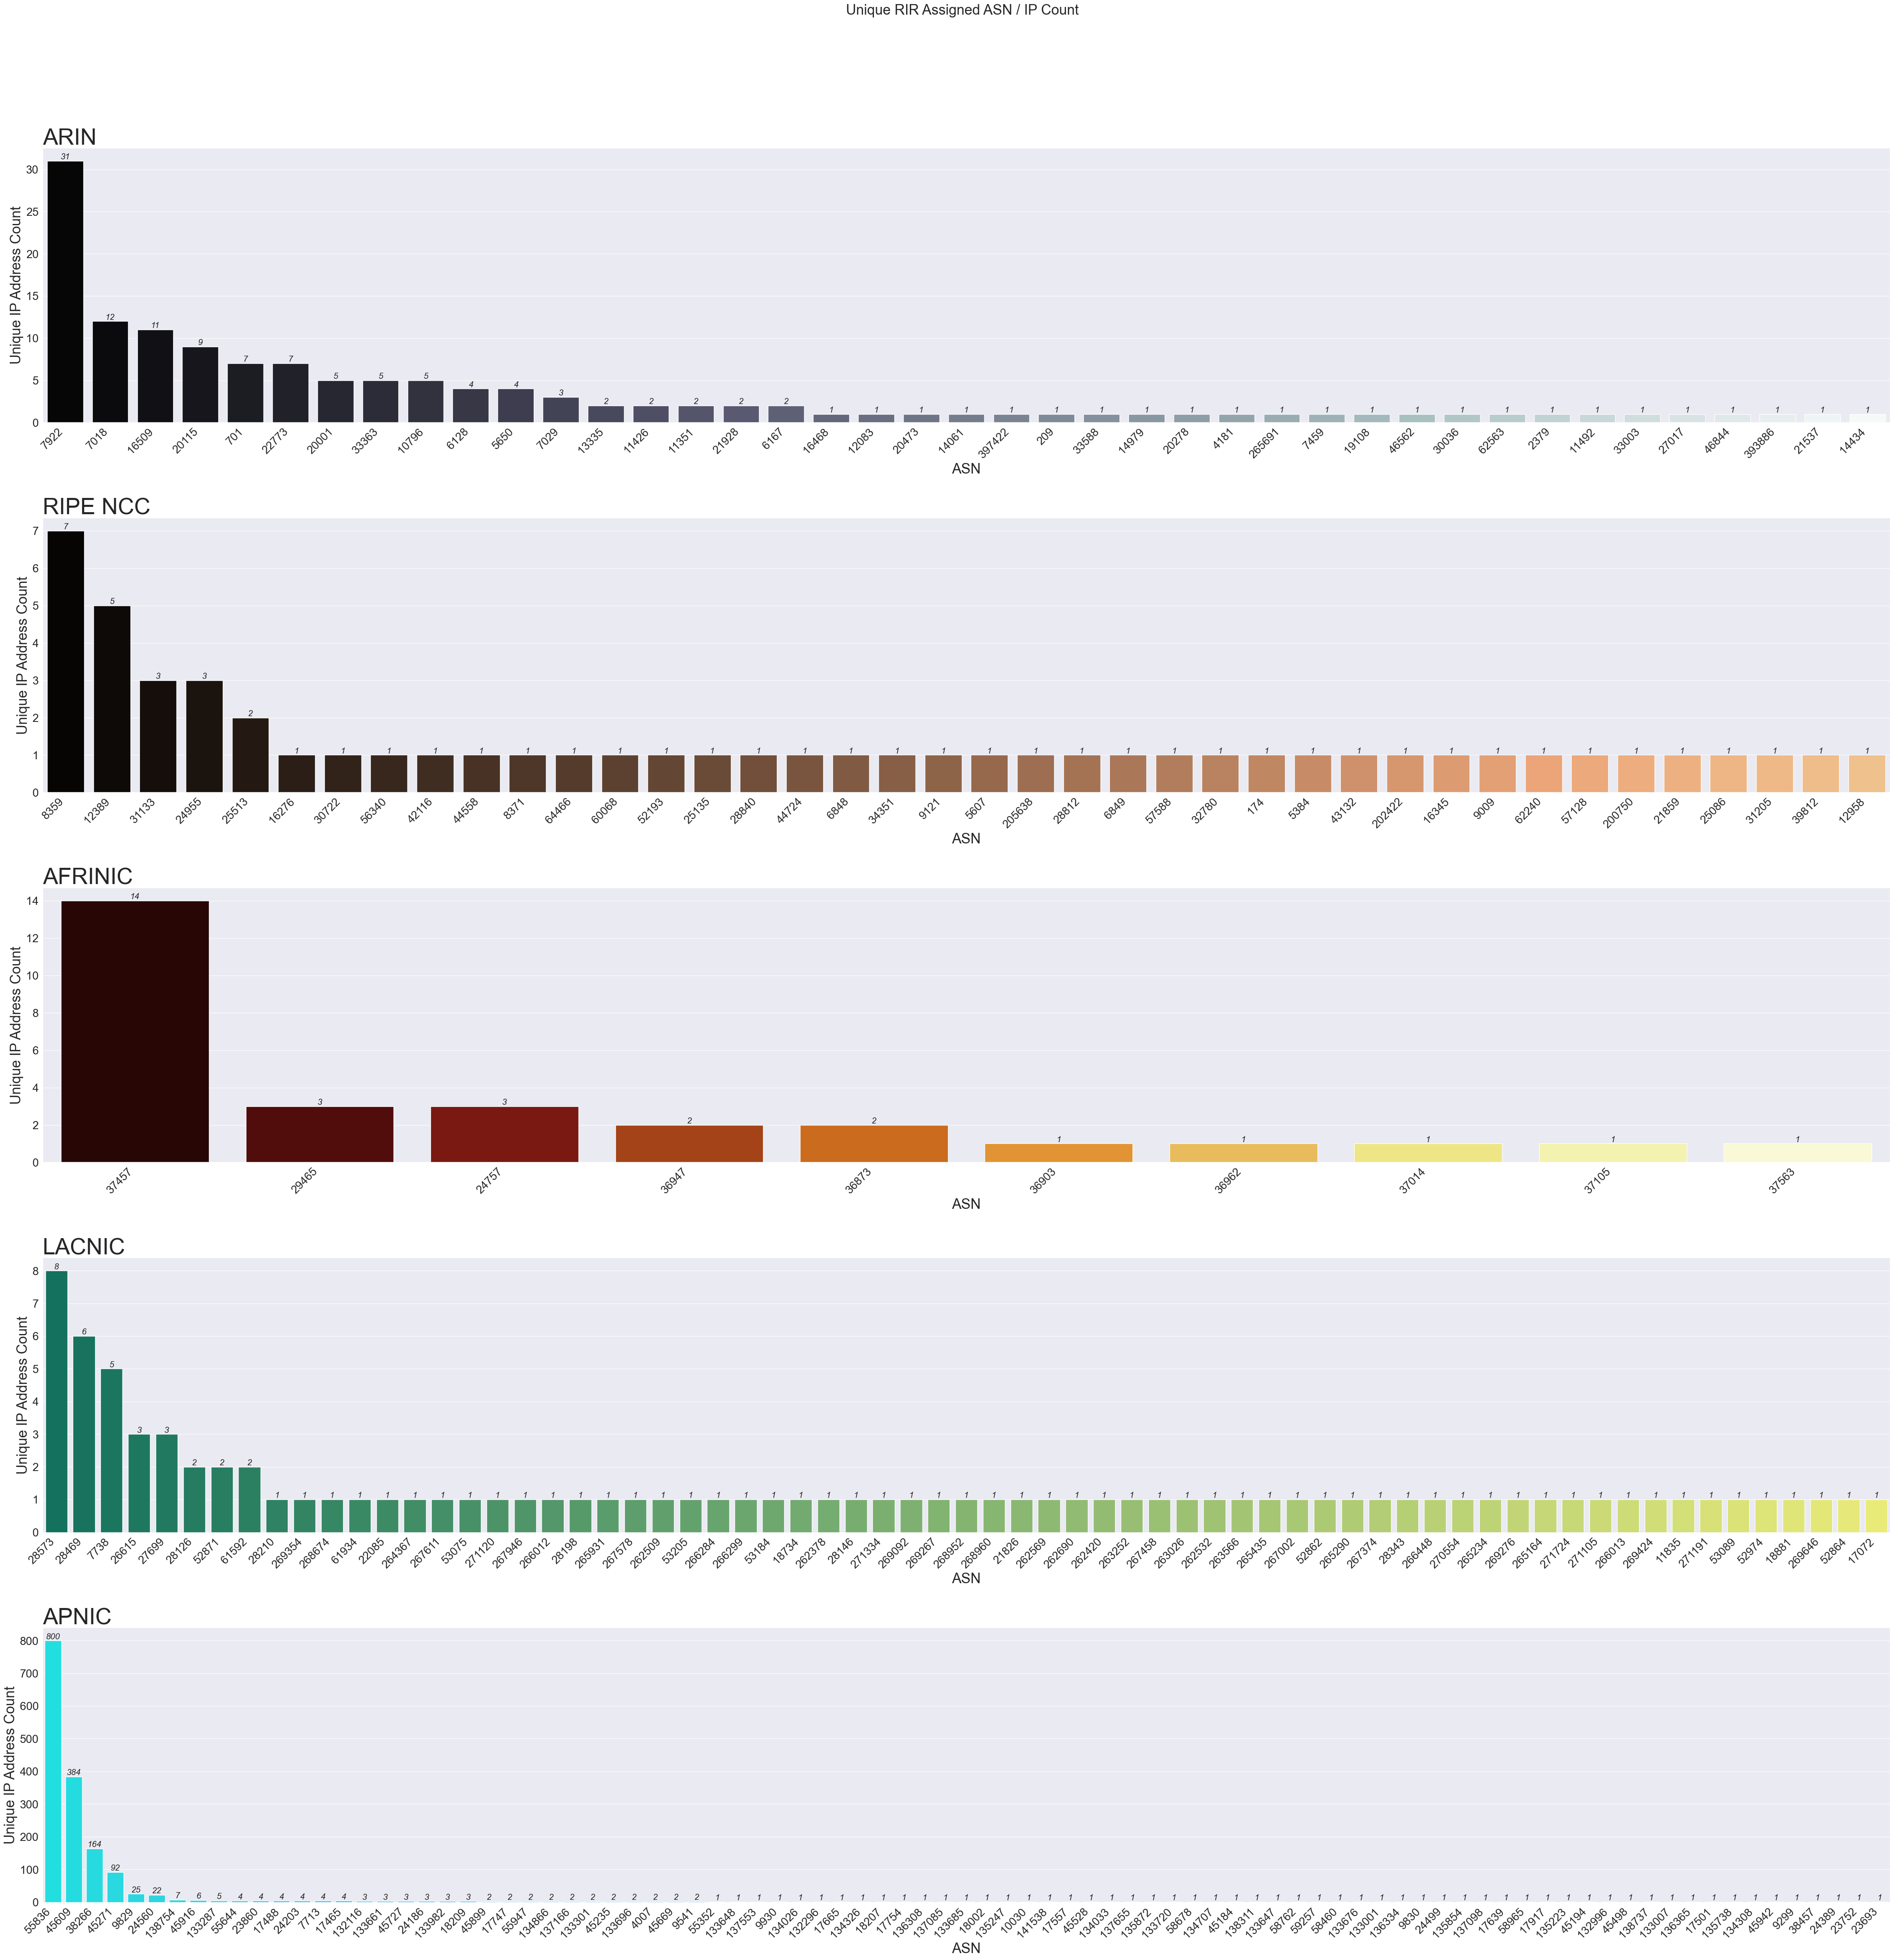

In [17]:
sns.set_style("darkgrid")

f, axs = plt.subplots(5,1,figsize=(50,50))
f.suptitle('Unique RIR Assigned ASN / IP Count', fontsize=25)
f.tight_layout(pad=15.0)


# ARIN
sns.countplot(x='ASN', data=df_arin, order=df_arin.ASN.value_counts().index, ax=axs[0], palette="bone")
axs[0].set_title('ARIN', fontsize=40, loc='left',)
axs[0].set_xlabel("ASN", fontsize=25)
axs[0].set_ylabel("Unique IP Address Count", fontsize=25)
axs[0].tick_params(labelsize=20)
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, horizontalalignment='right')

# Call function to add bar label of unique IP address count to top of bar.
bar_label_text(df_arin, 0)


# RIPE
sns.countplot(x='ASN', data=df_ripencc, order=df_ripencc.ASN.value_counts().index, ax=axs[1], palette="copper")
axs[1].set_title('RIPE NCC', fontsize=40, loc='left')
axs[1].set_xlabel("ASN", fontsize=25)
axs[1].set_ylabel("Unique IP Address Count", fontsize=25)
axs[1].tick_params(labelsize=20)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, horizontalalignment='right')

# Call function to add bar label of unique IP address count to top of bar.
bar_label_text(df_ripencc, 1)


# Afrinic
sns.countplot(x='ASN', data=df_afrinic, order=df_afrinic.ASN.value_counts().index, ax=axs[2], palette="afmhot")
axs[2].set_title('AFRINIC', fontsize=40, loc='left')
axs[2].set_xlabel("ASN", fontsize=25)
axs[2].set_ylabel("Unique IP Address Count", fontsize=25)
axs[2].tick_params(labelsize=20)
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=45, horizontalalignment='right')

# Call function to add bar label of unique IP address count to top of bar.
bar_label_text(df_afrinic, 2)


# Lacnic
sns.countplot(x='ASN', data=df_lacnic, order=df_lacnic.ASN.value_counts().index, ax=axs[3], palette="summer")
axs[3].set_title('LACNIC', fontsize=40, loc='left')
axs[3].set_xlabel("ASN", fontsize=25)
axs[3].set_ylabel("Unique IP Address Count", fontsize=25)
axs[3].tick_params(labelsize=20)
axs[3].set_xticklabels(axs[3].get_xticklabels(), rotation=45, horizontalalignment='right')

# Call function to add bar label of unique IP address count to top of bar.
bar_label_text(df_lacnic, 3)


# Apnic
sns.countplot(x='ASN', data=df_apnic, order=df_apnic.ASN.value_counts().index, ax=axs[4], palette="cool")
axs[4].set_title('APNIC', fontsize=40, loc='left')
axs[4].set_xlabel("ASN", fontsize=25)
axs[4].set_ylabel("Unique IP Address Count", fontsize=25)
axs[4].tick_params(labelsize=20)
axs[4].set_xticklabels(axs[4].get_xticklabels(), rotation=45, horizontalalignment='right')

# Call function to add bar label of unique IP address count to top of bar.
bar_label_text(df_apnic, 4)


#plt.legend()
plt.show()

### IP Address Count by RIR

  - We now want to compare all IP address counts by RIR
  - Build new df from df_tc that includes src_ip column, groupby RIR again.

- ip_count
- RIR

In [18]:
df_tc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1948 entries, 0 to 1947
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ip_count         1948 non-null   int64 
 1   src_ip           1948 non-null   object
 2   ASN              1937 non-null   object
 3   BGP Prefix       1937 non-null   object
 4   Country Code     1947 non-null   object
 5   RIR              1948 non-null   object
 6   Allocation Date  1936 non-null   object
 7   AS Description   1948 non-null   object
 8   AS Peers         1937 non-null   object
dtypes: int64(1), object(8)
memory usage: 137.1+ KB


In [19]:
df_arin.ip_count.sum()

673

In [20]:
df_afrinic.ip_count.sum()

250

In [21]:
df_ripencc.ip_count.sum()

1278

In [22]:
df_lacnic.ip_count.sum()

2580

In [23]:
df_apnic.ip_count.sum()

27547

In [24]:
df_lacnic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90 entries, 51 to 1947
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip_count        90 non-null     int64 
 1   ASN             90 non-null     object
 2   RIR             90 non-null     object
 3   AS Description  90 non-null     object
dtypes: int64(1), object(3)
memory usage: 3.5+ KB


### 3. Unique ASN Peers

 - Grouping by the unique ASN Peers will provide secondary insight into how attach traffic is reaching your network. 
 - With existing peering relationships a peer ASN can be central to numerious operators or networks. 
 - Additionally this helps show the aggregation of traffic as reporting / blocking a single network operator may not resolve the issue.
     - Subsequently a single network on their own maynot be able to generate the results captured leading to skepticism of their networks involvement.

### 4. ASN by RIR

In [25]:
# Make dataframe of specific columns
df_ip_analysis = df_tc[['ASN', 'AS Description', 'RIR', 'ip_count']].copy()

In [26]:
# How many entries per RIR
df_ip_analysis.groupby(['RIR']).size()

RIR
AFRINIC      29
APNIC      1626
ARIN        137
LACNIC       90
NONE         11
RIPENCC      55
dtype: int64

### 5. IP Address count by ASN Peers

- This further details the path the attack traffic is able to take and can provide insight into additional paths if the main Peering path starts getting filtered.

### 6. IP Count stats
* Use this data to help filter expected counts from the largest ip address.
    - Graph network diagram would be good here.

In [27]:
df_ip_analysis.groupby(['ip_count', 'RIR']).count().sort_values('ip_count', ascending=False)

ASN  AS Description
ip_count RIR                         
172      LACNIC     1               1
102      LACNIC     1               1
89       NONE       0               1
80       APNIC      1               1
78       APNIC      1               1
...               ...             ...
1        LACNIC     7               7
         ARIN      34              34
         APNIC    252             252
         RIPENCC    8               8
         AFRINIC   13              13

[194 rows x 2 columns]

* Above we see that Lacnic has the highest IP count by IP address.
* Apnic has the highest number of ASN entries of a single value.

---
<h4><span style='color:#8E5609;background:white'>www.threatlocus.com &copy</span></h4>

Copyright (C) 2022 www.threatlocus.com / Stephen Scally

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.

---